# Data Preparation

In [1]:
import numpy as np 
import pandas as pd

from datetime import datetime

In [38]:
def clean_dataset(df):
    # from id
    df["id"] = df["id"].str.extract(r"AS14\.(\d{2})")[0].astype(float).astype(int)
    
    # from time (ensure it's in datetime format)
    df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f")  # Keep as datetime
    df["time"] = df["time"].dt.floor('s')  # Remove milliseconds by flooring to seconds
    
    # Extract required columns
    df["date"] = df["time"].dt.date  # Extract date
    df["day_of_the_week"] = df["time"].dt.day_name()  # Extract day name
    df["hour_of_the_day"] = df["time"].dt.hour  # Extract hour

    # from variable
    df['record_type'] = df['variable'].apply(
        lambda x: {
            'appCat': 'app','circumplex': 'sensor'}.get(x.split('.')[0], x.split('.')[0])
        )
    df['record_detail'] = df['variable'].apply(
        lambda x: x.split('.')[1] if len(x.split('.')) > 1 else None
    )

    # select relevant columns
    relevant_cols = [
        'id',
        'time',
        'date',
        'day_of_the_week',
        'hour_of_the_day',
        'record_type',
        'record_detail',
        'value']
    df = df[relevant_cols]

    # normalize values according to their desired range
    # Define the interval mapping structure
    interval_mapping = {
        ('mood', None): {
            'current_interval': [1, 10],
            'desired_interval': [0, 1]
        },
        ('sensor', 'arousal'): {
            'current_interval': [-2, 2],
            'desired_interval': [0, 1]
        },
        ('sensor', 'valence'): {
            'current_interval': [-2, 2],
            'desired_interval': [0, 1]
        }
    }
    for index, row in df.iterrows():
        # Get the combination of record_type and record_detail
        record_key = (row['record_type'], row['record_detail'])
        # Check if the combination exists in the interval mapping
        if record_key in interval_mapping:
            current_interval = interval_mapping[record_key]['current_interval']
            desired_interval = interval_mapping[record_key]['desired_interval']
            # Normalize the value
            current_min, current_max = current_interval
            desired_min, desired_max = desired_interval
            # Min-max normalization formula
            normalized_value = (row['value'] - current_min) / (current_max - current_min) * (desired_max - desired_min) + desired_min
            # Assign the normalized value to the dataframe (using .at for setting a value)
            df.at[index, 'normalized_value'] = normalized_value
        # If no mapping is found, return the original value
        else:
            # If no mapping is found, just copy the original value
            df.at[index, 'normalized_value'] = row['value']

    return df

# Load dataset
dataset_path = 'ass1/data/dataset_mood_smartphone.csv'
df_raw = pd.read_csv(dataset_path, index_col=False).drop(columns='Unnamed: 0')

# Clean dataset
df = clean_dataset(df_raw)

# Save cleaned dataset
cleaned_dataset_path = 'ass1/data/dataset_clean.csv'
df.to_csv(cleaned_dataset_path, index=False)

In [39]:
df

,id,time,date,day_of_the_week,hour_of_the_day,record_type,record_detail,value,normalized_value
0,1,2014-02-26 13:00:00,2014-02-26,Wednesday,13,mood,None,6.000,0.555556
1,1,2014-02-26 15:00:00,2014-02-26,Wednesday,15,mood,None,6.000,0.555556
2,1,2014-02-26 18:00:00,2014-02-26,Wednesday,18,mood,None,6.000,0.555556
3,1,2014-02-26 21:00:00,2014-02-26,Wednesday,21,mood,None,7.000,0.666667
4,1,2014-02-27 09:00:00,2014-02-27,Thursday,9,mood,None,6.000,0.555556
...,...,...,...,...,...,...,...,...,...
376907,30,2014-04-11 07:51:16,2014-04-11,Friday,7,app,weather,8.032,8.032000
376908,30,2014-04-19 11:00:32,2014-04-19,Saturday,11,app,weather,3.008,3.008000
376909,30,2014-04-26 10:19:07,2014-04-26,Saturday,10,app,weather,7.026,7.026000
376910,30,2014-04-27 00:44:48,2014-04-27,Sunday,0,app,weather,23.033,23.033000


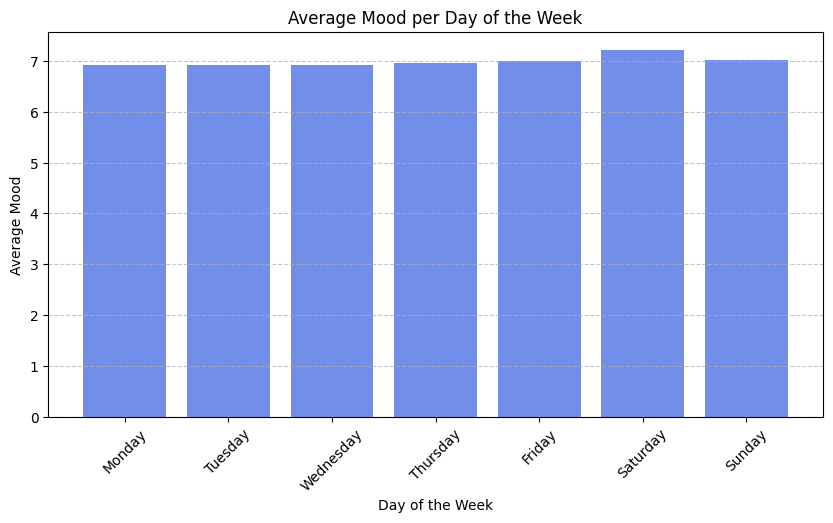

In [14]:
import matplotlib.pyplot as plt

# Filter only 'mood' records
mood_df = df[df["record_type"] == "mood"]

# Compute average mood per day_of_the_week
avg_mood = mood_df.groupby("day_of_the_week")["value"].mean()

# Sort by actual weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_mood = avg_mood.reindex(weekday_order)

# Plot using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_mood.index, avg_mood.values, color="royalblue", alpha=0.75)

# Labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Average Mood")
plt.title("Average Mood per Day of the Week")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

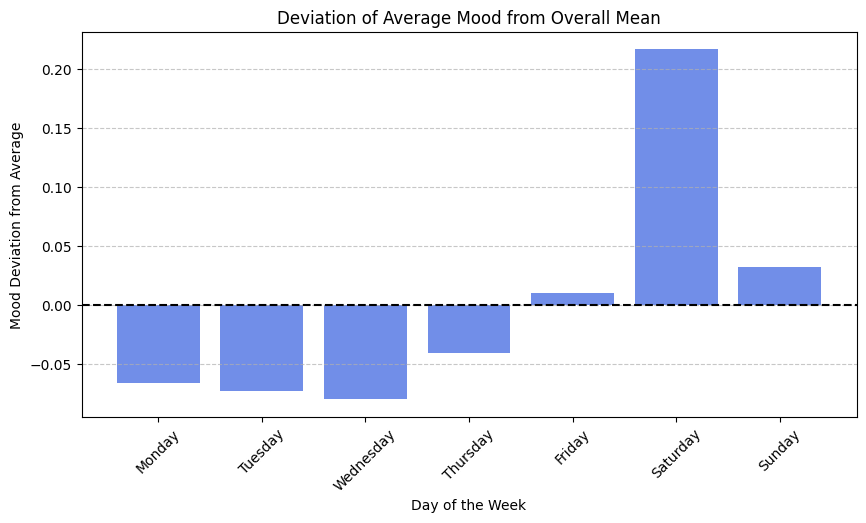

In [15]:
import matplotlib.pyplot as plt

# Filter only 'mood' records
mood_df = df[df["record_type"] == "mood"]

# Compute average mood per day_of_the_week
avg_mood = mood_df.groupby("day_of_the_week")["value"].mean()

# Compute the overall average mood
overall_avg_mood = avg_mood.mean()

# Subtract the overall average to show deviations
avg_mood_diff = avg_mood - overall_avg_mood

# Sort by actual weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_mood_diff = avg_mood_diff.reindex(weekday_order)

# Plot using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_mood_diff.index, avg_mood_diff.values, color="royalblue", alpha=0.75)

# Add a horizontal line at 0 for reference
plt.axhline(0, color="black", linewidth=1.5, linestyle="--")

# Labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Mood Deviation from Average")
plt.title("Deviation of Average Mood from Overall Mean")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

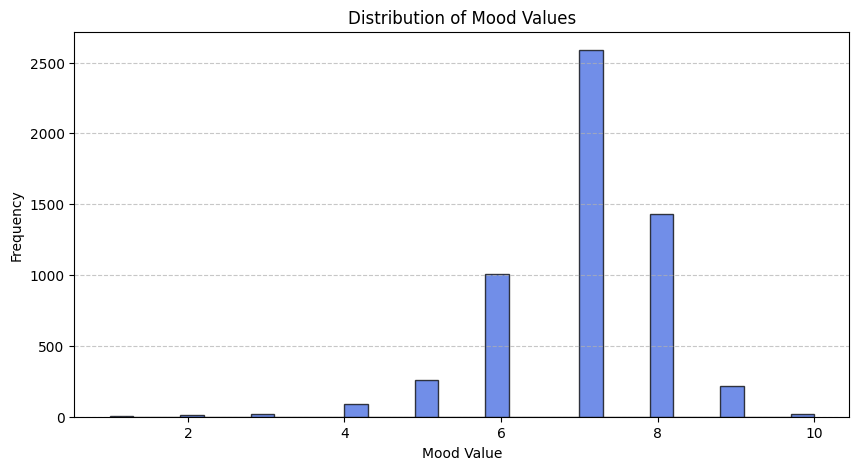

In [16]:
import matplotlib.pyplot as plt

# Filter only 'mood' records
mood_df = df[df["record_type"] == "mood"]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(mood_df["value"], bins=30, color="royalblue", edgecolor="black", alpha=0.75)

# Labels and title
plt.xlabel("Mood Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mood Values")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

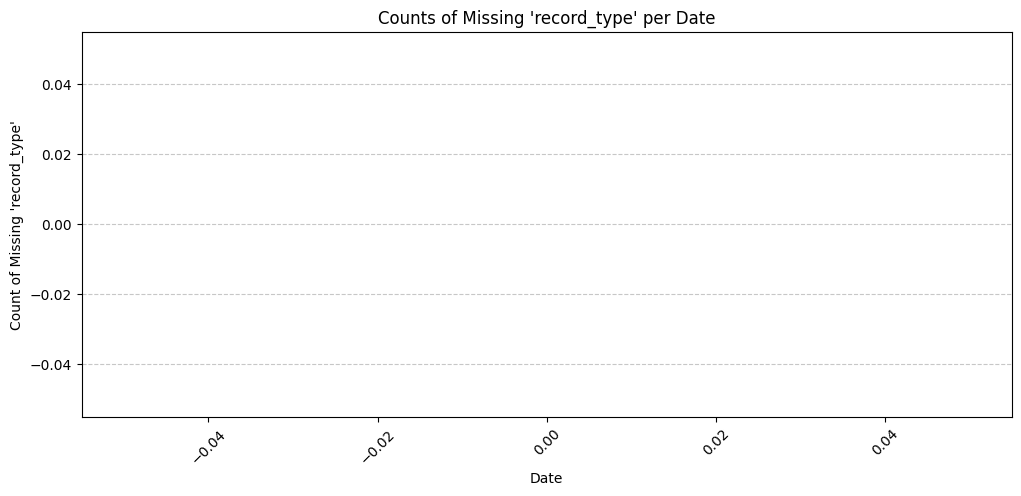

In [24]:
import matplotlib.pyplot as plt

# Filter rows where record_type is NaN
dataset_path = 'ass1/data/dataset_mood_smartphone.csv'
df_raw = pd.read_csv(dataset_path, index_col=False).drop(columns='Unnamed: 0')
df_raw["time"] = pd.to_datetime(df_raw["time"], format="%Y-%m-%d %H:%M:%S.%f")  # Keep as datetime

df_raw["date"] = df_raw["time"].dt.date  # Extract date

missing_activity_df = df_raw[df_raw["variable"].isna()]

# Count missing entries per date
missing_counts = missing_activity_df["date"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(missing_counts.index, missing_counts.values, color="crimson", alpha=0.75)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Count of Missing 'record_type'")
plt.title("Counts of Missing 'record_type' per Date")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()